In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import librosa
from IPython.display import Audio 
from collections import defaultdict

In [38]:
from mpl_toolkits import mplot3d
from collections import defaultdict
from scipy.stats.stats import pearsonr
from scipy.stats import shapiro
from scipy.stats import normaltest
from pandas.plotting import parallel_coordinates
from kneed import KneeLocator

In [2]:
X_train = np.load("RavdessAudioOnlyNumpy__X_train.npy")
X_test = np.load("RavdessAudioOnlyNumpy__X_test.npy")
y_train=pd.read_csv("RavdessAudioOnlyNumpy__Y_train.csv")
y_test=pd.read_csv("RavdessAudioOnlyNumpy__Y_test.csv")
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(1828, 304304) (624, 304304)
(1828, 9) (624, 9)


In [3]:
X_train[np.isnan(X_train)] = 0
X_test[np.isnan(X_test)] = 0

In [4]:
df_train=pd.DataFrame(X_train)
df_test=pd.DataFrame(X_test)

## Transformations

In [5]:
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from scipy.signal import decimate

In [6]:
'''
X_train_decimated=decimate(X_train,axis=1,q=8)
X_test_decimated=decimate(X_test,axis=1,q=8)
np.save("RavdessAudioOnlyNumpy__X_train_decimated.npy",X_train_decimated)
np.save("RavdessAudioOnlyNumpy__X_test_decimated.npy",X_test_decimated)
'''

'\nX_train_decimated=decimate(X_train,axis=1,q=8)\nX_test_decimated=decimate(X_test,axis=1,q=8)\nnp.save("RavdessAudioOnlyNumpy__X_train_decimated.npy",X_train_decimated)\nnp.save("RavdessAudioOnlyNumpy__X_test_decimated.npy",X_test_decimated)\n'

In [7]:
X_train_decimated = np.load("RavdessAudioOnlyNumpy__X_train_decimated.npy")
X_test_decimated = np.load("RavdessAudioOnlyNumpy__X_test_decimated.npy")

In [8]:
df_train_decimated=pd.DataFrame(X_train_decimated)
df_test_decimated=pd.DataFrame(X_test_decimated)

In [9]:
scaler = TimeSeriesScalerMeanVariance(mu=0, std=1)

In [10]:
X_train_decimated_scaled=scaler.fit_transform(X_train_decimated)
X_test_decimated_scaled=scaler.transform(X_test_decimated)

In [11]:
X_train_decimated_scaled=X_train_decimated_scaled[:,:,0]
X_test_decimated_scaled=X_test_decimated_scaled[:,:,0]

In [12]:
np.save("RavdessAudioOnlyNumpy__X_train_decimated_scaled.npy",X_train_decimated_scaled)
np.save("RavdessAudioOnlyNumpy__X_test_decimated_scaled.npy",X_test_decimated_scaled)

In [13]:
df_train_decimated_scaled=pd.DataFrame(X_train_decimated_scaled)
df_test_decimated_scaled=pd.DataFrame(X_test_decimated_scaled)

Confronting the transformations

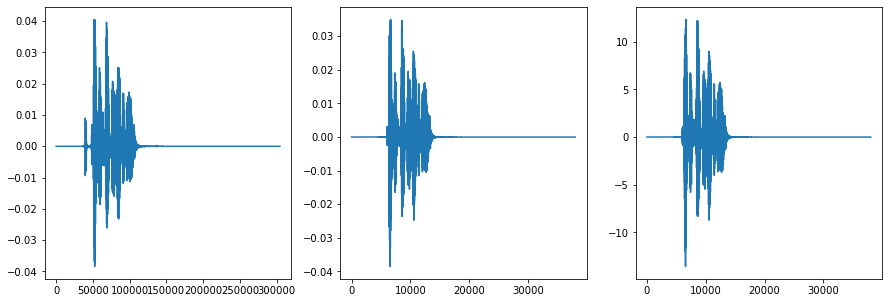

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(df_train.iloc[0])
ax2.plot(df_train_decimated.iloc[0])
ax3.plot(df_train_decimated_scaled.iloc[0])
plt.show()

In [15]:
df_train.iloc[0].mean(), df_train_decimated.iloc[0].mean(), df_train_decimated_scaled.iloc[0].mean()

(4.7676194334037675e-07, 4.7130478586277917e-07, -2.825998700912553e-18)

In [16]:
df_train.iloc[0].std(), df_train_decimated.iloc[0].std(), df_train_decimated_scaled.iloc[0].std()

(0.002887818716104438, 0.002834538741339087, 1.0000131450095302)

## Rolling Window

In [17]:
window=10
df_train_decimated_scaled_smoothed=df_train_decimated_scaled.T.rolling(window=window).mean()
df_test_decimated_scaled_smoothed=df_test_decimated_scaled.T.rolling(window=window).mean()

In [18]:
df_train_decimated_scaled_smoothed=df_train_decimated_scaled_smoothed.T
df_train_decimated_scaled_smoothed=df_train_decimated_scaled_smoothed.iloc[:,(window-1):]

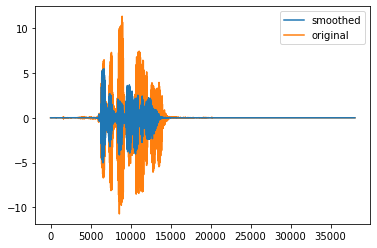

In [19]:
df_train_decimated_scaled_smoothed.iloc[0].plot(label="smoothed")
df_test_decimated_scaled.iloc[0].plot(zorder=1,label="original")
plt.legend()
plt.show()

In [20]:
df_train_decimated_scaled_smoothed

,9,10,11,12,13,14,15,16,17,18,...,38028,38029,38030,38031,38032,38033,38034,38035,38036,38037
0,0.000289,0.000379,0.000370,0.000356,0.000390,0.000325,0.000232,0.000231,0.000132,0.000016,...,-0.000166,-0.000166,-0.000166,-0.000166,-0.000166,-0.000166,-0.000166,-0.000166,-0.000166,-0.000166
1,-0.001549,-0.001508,-0.001488,-0.001139,-0.000854,-0.000850,-0.000703,-0.000570,-0.000464,-0.000178,...,-0.000122,-0.000122,-0.000122,-0.000122,-0.000122,-0.000122,-0.000122,-0.000122,-0.000122,-0.000122
2,0.006718,0.006332,0.005853,0.005480,0.005004,0.004120,0.003993,0.004159,0.003558,0.002787,...,-0.000137,-0.000137,-0.000137,-0.000137,-0.000137,-0.000137,-0.000137,-0.000137,-0.000137,-0.000137
3,0.003412,0.002562,0.002495,0.001385,0.000774,0.000978,0.000623,0.000016,-0.000069,0.000008,...,-0.000135,-0.000135,-0.000135,-0.000135,-0.000135,-0.000135,-0.000135,-0.000135,-0.000135,-0.000135
4,0.000980,-0.000405,-0.000194,-0.000248,-0.000234,-0.000209,-0.000223,-0.000200,-0.000208,-0.000190,...,-0.000206,-0.000206,-0.000206,-0.000206,-0.000206,-0.000206,-0.000206,-0.000206,-0.000206,-0.000206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1823,0.000130,0.000129,0.000129,0.000131,0.000127,0.000133,0.000124,0.000135,0.000124,0.000037,...,0.000129,0.000129,0.000129,0.000129,0.000129,0.000129,0.000129,0.000129,0.000129,0.000129
1824,-0.000055,-0.000119,-0.000149,-0.000160,-0.000273,-0.000395,-0.000459,-0.000516,-0.000519,-0.000521,...,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072,0.000072
1825,0.000097,0.000094,0.000096,0.000098,0.000057,0.000037,0.000046,0.000041,0.000042,0.000044,...,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095,0.000095
1826,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,...,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031,0.000031


## Fourier Transform

In [21]:
from pyts.approximation import DiscreteFourierTransform

In [22]:
n_coefs=16384
dft = DiscreteFourierTransform(n_coefs=n_coefs)

In [23]:
X_train_decimated_scaled_ft=dft.fit_transform(X_train_decimated_scaled)
X_test_decimated_scaled_ft=dft.transform(X_test_decimated_scaled)

In [24]:
# code derived from https://pyts.readthedocs.io/en/stable/auto_examples/approximation/plot_dft.html
def dft_inverse_trasform(X_dft, n_coefs, n_timestamps):
    # Compute the inverse transformation
    n_samples = X_dft.shape[0]
    if n_coefs % 2 == 0:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * np.c_[X_dft[:, imag_idx],
                                            np.zeros((n_samples, ))]
        ]
    else:
        real_idx = np.arange(1, n_coefs, 2)
        imag_idx = np.arange(2, n_coefs + 1, 2)
        X_dft_new = np.c_[
            X_dft[:, :1],
            X_dft[:, real_idx] + 1j * X_dft[:, imag_idx]
        ]
    X_irfft = np.fft.irfft(X_dft_new, n_timestamps)
    return X_irfft

In [25]:
X_train_decimated_scaled_ft[0].shape

(16384,)

In [26]:
X_train_decimated_scaled_ft_inv=dft_inverse_trasform(X_train_decimated_scaled_ft, n_coefs=n_coefs, n_timestamps=len(X_train_decimated_scaled[0]))
X_test_decimated_scaled_ft_inv=dft_inverse_trasform(X_test_decimated_scaled_ft, n_coefs=n_coefs, n_timestamps=len(X_test_decimated_scaled[0]))

In [27]:
X_train_decimated_scaled_ft_inv.shape, X_train_decimated_scaled.shape

((1828, 38038), (1828, 38038))

In [28]:
X_test_decimated_scaled_ft_inv.shape, X_test_decimated_scaled.shape

((624, 38038), (624, 38038))

In [29]:
df_train_decimated_scaled_ft_inv=pd.DataFrame(X_train_decimated_scaled_ft_inv)
df_test_decimated_scaled_ft_inv=pd.DataFrame(X_test_decimated_scaled_ft_inv)

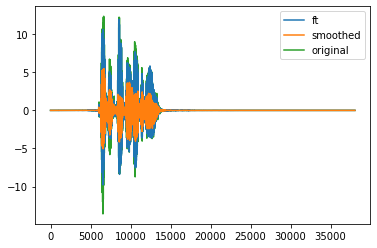

In [30]:
df_train_decimated_scaled_ft_inv.iloc[0].plot(label="ft")
df_train_decimated_scaled_smoothed.iloc[0].plot(label="smoothed")
df_train_decimated_scaled.iloc[0].plot(zorder=0,label="original")
plt.legend()
plt.show()

In [31]:
np.save("RavdessAudioOnlyNumpy__X_train_decimated_scaled_ft.npy",X_train_decimated_scaled_ft_inv)
np.save("RavdessAudioOnlyNumpy__X_test_decimated_scaled_ft.npy",X_test_decimated_scaled_ft_inv)

## Dealing with the zeros

In [32]:
df_train_decimated_scaled_denoised=df_train_decimated_scaled[abs(df_train_decimated_scaled) > 0.1]

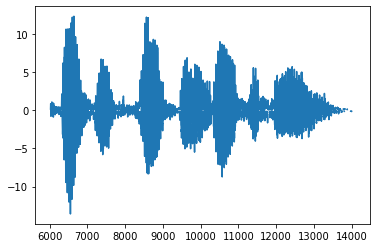

In [33]:
df_train_decimated_scaled_denoised.iloc[0].plot()
plt.show()

# Clustering

In [34]:
from tslearn.clustering import TimeSeriesKMeans

In [39]:
km = TimeSeriesKMeans(n_clusters=3, metric="euclidean", 
                      max_iter=5, random_state=0)
km.fit(np.squeeze(df_train_decimated_scaled_denoised).T)

TimeSeriesKMeans(max_iter=5, random_state=0)

In [40]:
km.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [42]:
km.inertia_

inf

In [41]:
kmeans = TimeSeriesKMeans(n_clusters=5, metric="euclidean", 
                      max_iter=5, random_state=0)
kmeans.fit(np.squeeze(df_train_decimated_scaled_denoised).T)
hist, bins = np.histogram(kmeans.labels_, bins=range(0, len(set(kmeans.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('sse', kmeans.inertia_)
print('silhouette', silhouette_score(np.squeeze(df_train_decimated_scaled_denoised).T, kmeans.labels_))

ValueError: cannot reshape array of size 0 into shape (0,newaxis)